Identificar os coeficientes do MP já levando em consideração, durante a identificação, que as operações serão idênticas às da FPGA, ou seja, manipulam-se apenas números inteiros e usam-se apenas somadores e multiplicadores de 2 entradas. Usar a estrutura de function feita na Atividade M2. Importante: a remoção de metade dos bits após cada multiplicação é uma operação não linear e por isso justifica-se usar um otimizador não linear. O objetivo é encontrar coeficientes que são números inteiros, então buscar por um otimizador não linear inteiro.

In [52]:
from scipy.io import loadmat
import numpy as np

mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction'].flatten()
out_data_ext = mat['out_extraction'].flatten()
in_data_val = mat['in_validation'].flatten()
out_data_val = mat['out_validation'].flatten()

lista = [in_data_ext, out_data_ext, in_data_val, out_data_val]

modulos = []
for i in lista:
    modulos.append(max(i.imag))
    modulos.append(max(i.real))

maior_modulo = max(modulos)

in_ext_norm  = in_data_ext / maior_modulo
out_ext_norm = out_data_ext / maior_modulo
in_val_norm  = in_data_val / maior_modulo
out_val_norm = out_data_val / maior_modulo


p_bits = 20
    
in_val_fixed = np.round(in_val_norm * (2 ** p_bits)) 
out_val_fixed = np.round(out_val_norm * (2 ** p_bits))


In [53]:

import numpy as np

nmse_calculo = lambda predicted_val, data_out:10 * np.log10(np.mean(np.abs(data_out - predicted_val) ** 2) / np.mean(np.abs(data_out) ** 2))

def mp(P, M, xn, coef):
    L = xn.shape[0]

    y_est = np.zeros(L, dtype=complex)
    idx = 0
    for k in range(M+1):
        xk = np.roll(xn, k)
        for p in range(1, P+1):
            y_est += coef[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1
    return y_est


def erro_mp_complex_float(params, x_in, y_out, ordem, memoria):
    num_coef = ordem * (memoria+1)
    # Reconstruct complex params
    ar = params[:num_coef]
    ai = params[num_coef:]
    coefs = ar + 1j*ai

    N = len(x_in)
    y_est = mp(ordem, memoria, x_in.flatten(), coefs)

    erro = y_out - y_est
    return np.abs(erro)**2


In [54]:
from scipy.optimize import least_squares

ordem = 3
memoria = 2
num_coef = ordem * (memoria+1)

# Vetor inicial: separar parte real e imaginária
params = 0.01*np.random.randn(2*num_coef)

res = least_squares(
    erro_mp_complex_float,
    params,
    args=(in_ext_norm, out_ext_norm, ordem, memoria),
    verbose=2
)

coef_otimo_norm = res.x[:num_coef] + 1j*res.x[num_coef:]
print("Coeficientes complexos otimizados:", coef_otimo_norm)

# Calcular MSE na validação
erro_val = erro_mp_complex_float(res.x, in_data_val, out_data_val, ordem, memoria)
mse_val = np.mean(erro_val**2)
print("MSE validação:", mse_val)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8744e+02                                    8.73e+02    
       1              2         1.2724e+02      6.02e+01       3.91e-02       6.51e+02    
       2              3         5.2682e+01      7.46e+01       7.82e-02       3.32e+02    
       3              4         6.0590e+00      4.66e+01       1.56e-01       5.92e+01    
       4              5         4.8069e-01      5.58e+00       3.13e-01       7.91e+00    
       5              6         1.6856e-01      3.12e-01       6.25e-01       2.73e+00    
       6              7         1.7430e-02      1.51e-01       5.89e-01       4.23e-01    
       7              8         3.8100e-03      1.36e-02       6.25e-01       2.56e-02    
       8             11         3.7812e-03      2.88e-05       7.82e-02       5.98e-02    
       9             12         3.4365e-03      3.45e-04       1.95e-02       4.70e-02    

valor de NMSE: -25.514961159256


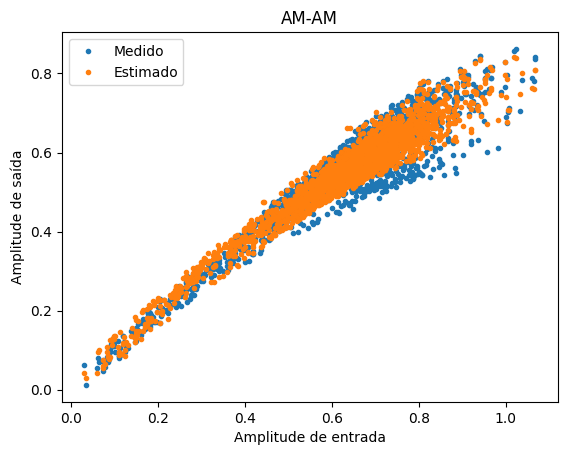

In [55]:
import matplotlib.pyplot as plt

predicted_val = mp(ordem, memoria, in_val_norm, coef_otimo_norm)

nmse_target = nmse_calculo(predicted_val[memoria:], out_val_norm[memoria:])

print(f"valor de NMSE: {nmse_target}")

plt.figure()
plt.plot(np.abs(in_val_norm[memoria:]), np.abs(out_val_norm[memoria:]), '.', label='Medido')
plt.plot(np.abs(in_val_norm[memoria:]), np.abs(predicted_val[memoria:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.show()

In [56]:
def modulo_preservando_sinal(dividendo, divisor):
    resto = dividendo % divisor
    return resto if dividendo >= 0 else resto - divisor

def readeq_int(val, precision):
    """Readequação de bits (divisão por 2**precision, truncando)."""
    return val >> precision


# Reconstruindo o modelo para validação já quantizado
def aplica_modelo_int(x, coef_int, ordem, memoria, precision):
    N = len(x)
    idx = 0
    y_est = np.zeros(N, dtype=complex)

    for n in range(memoria, N):
        soma_real : int = 0
        soma_imag : int = 0
        idx = 0

        for m in range(memoria+1):
            for p in range(1, ordem+1):
                # calcula x_in^(p)
                xr = np.real(x[n-m]).astype(int)
                xi = np.imag(x[n-m]).astype(int)
                # potência complexa com readequação a cada multiplicação
                modulo_power = 2**precision 
                modulo_square = readeq_int(xr ** 2, precision) + readeq_int(xi ** 2, precision)
                for _ in range(1, p):
                    modulo_power = readeq_int(modulo_power * modulo_square, precision)
                xr_p = modulo_preservando_sinal(readeq_int(xr * modulo_power,precision), 2**precision) 
                xi_p = modulo_preservando_sinal(readeq_int(xi * modulo_power,precision), 2**precision) 

                # multiplicação coef * x^p com readequação
                ar = int(np.real(coef_int[idx]))
                ai = int(np.imag(coef_int[idx]))

                prod_real = readeq_int(ar * xr_p - ai * xi_p, precision)
                prod_imag = readeq_int(ar * xi_p + ai * xr_p, precision)

                soma_real += prod_real
                soma_imag += prod_imag
                idx += 1

        y_est[n] = int(soma_real) + 1j * int(soma_imag)

    return y_est


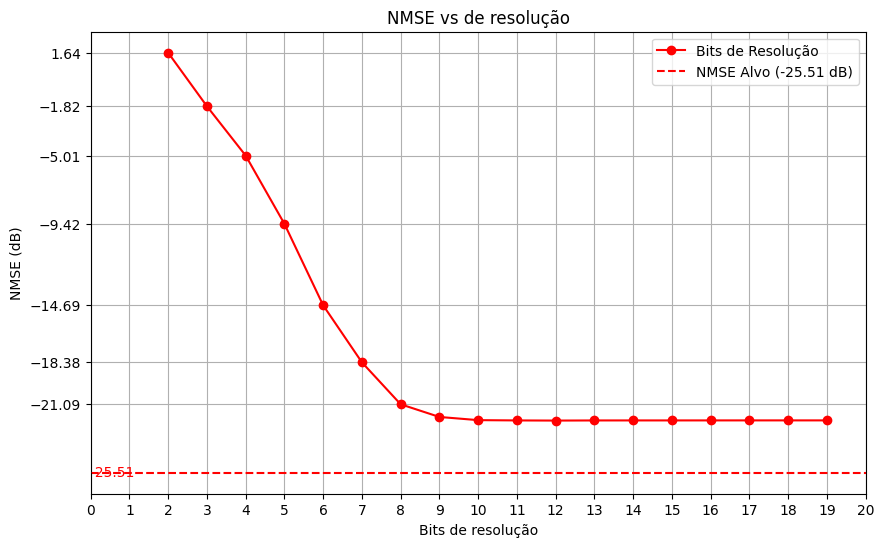

In [57]:
nmse_values = []

for p_bits in range(2, 20):
    # print(f'{np.round(coefficients * (2 ** p_bits))}')
    scale = 2**p_bits
    coef_int = np.round(coef_otimo_norm * scale)
    in_data_val_fixed = np.round(in_val_norm * scale) 
    out_data_val_fixed = np.round(out_val_norm * scale)

    # print(f"Coeficientes inteiros quantizados: {coef_int}")
    pred_val_int = aplica_modelo_int(in_data_val_fixed, coef_int, ordem, memoria, p_bits)
    mse_val_int = nmse_calculo(pred_val_int[memoria:], out_data_val_fixed[memoria:])

    # print("MSE validação quantizado:", mse_val_int)
    nmse_values.append((p_bits, mse_val_int))

nmse_values = np.array(nmse_values)
resol_bits_array = nmse_values[:, 0]
nmse_fixed_array = nmse_values[:, 1]
plt.figure(figsize=(10, 6))
# plt.plot(total_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='b', label='Bits Totais')
plt.plot(resol_bits_array, nmse_fixed_array, marker='o', linestyle='-', color='r', label='Bits de Resolução')

# Adicionar títulos e labels
plt.title('NMSE vs de resolução')
plt.xlabel('Bits de resolução')
plt.ylabel('NMSE (dB)')
plt.xticks(np.arange(0, max(resol_bits_array) + 2, 1))
plt.yticks(nmse_fixed_array[:7])

plt.axhline(y=nmse_target, color='r', linestyle='--', label=f'NMSE Alvo ({nmse_target:.4} dB)')
plt.text(0, nmse_target, f'{nmse_target:.4}', color='r', verticalalignment='center')

plt.legend()
plt.grid(True)
plt.show()

# Extração de Coeficientes quantizados 8 bits de resolução

In [63]:
ordem = 3
memoria = 2
precision = 8

scale = 2**precision

in_data_ext_fixed  = np.round(in_ext_norm  * scale)
out_data_ext_fixed = np.round(out_ext_norm * scale)

num_coefs = ordem * (memoria + 1)
total_params = 2 * num_coefs   # real + imag


# --- converte coeficientes float para INTEIRO de 8 bits ---
coefs_real_float = np.real(coef_otimo_norm)
coefs_imag_float = np.imag(coef_otimo_norm)

# vetor inicial no formato do otimizador
params_float = np.hstack([coefs_real_float, coefs_imag_float])

In [ ]:
def objetivo(params, x, y, ordem, memoria, precision):
    scale = 2**precision
    params = np.round(params * (scale - 1)).astype(int)
    num_coefs = ordem * (memoria + 1)
    ar = params[:num_coefs]
    ai = params[num_coefs:]
    coefs = ar + 1j * ai 
    y_pred = aplica_modelo_int(x.flatten(), coefs, ordem, memoria, precision)
    nmse = nmse_calculo(y_pred[memoria:], y[memoria:])
    print(nmse)
    return nmse

in_data_val_fixed = np.round(in_val_norm * scale) 
out_data_val_fixed = np.round(out_val_norm * scale)
objetivo_inicial = objetivo(
    params_float.astype(float),
    in_data_val_fixed,
    out_data_val_fixed,
    ordem,
    memoria,
    precision
)

print("NMSE inicial (inteiros):", objetivo_inicial)

-20.974309033231172
NMSE inicial (inteiros): -20.974309033231172


In [ ]:

ordem = 3
memoria = 2

num_coefs = ordem * (memoria + 1)
total_params = 2 * num_coefs

# Exemplo: coeficientes entre -1.0 e +1.0 em FLOAT
# → em inteiro isso vira:
coef_min = -1.0
coef_max =  1.0

bounds = [
    (coef_min , coef_max)
] * total_params

from scipy.optimize import dual_annealing

result = dual_annealing(
    objetivo,
    bounds,
    x0=x0_int_from_float.astype(float),
    args=(in_data_ext_fixed, out_data_ext_fixed, ordem, memoria, precision),
    maxiter=500,
    initial_temp=5230,
    visit=2.7,
    accept=-5.0,
    no_local_search=True   # MUITO IMPORTANTE PARA PROBLEMA DISCRETO
)

print("Melhor solução (inteiros):")
params_int = np.round(result.x * (scale - 1)).astype(int)
print(params_int)

print("Melhor NMSE:")
print(result.fun)

# Converter para coeficientes finais em float quantizado
coefs_finais = (params_int[:num_coefs] + 1j * params_int[num_coefs:]) 



-19.45291475922019
4.1471534523045355
8.181282854043143
4.080815598140347
-0.8778652231377747
6.177343063263883
3.3967162811226137
2.510830955429087
6.857826244412456
8.419505462592126
-1.1323270618704169
9.27064048124339
9.883832091589076
7.513769061904691
-1.0264307554126169
3.7548148510220964
9.02907284599461
-1.727633359591717
5.718034944889549
-0.9812992398399296
-2.978362309755526
-2.9815232955541537
-1.1648448996277845
-2.7283749563608146
-3.4781817712620327
-1.5919520844729318
-1.6746442285570085
-1.654465615399955
2.896995095869696
1.4521995607309295
-0.00890778857287649
2.8640498358183293
2.769649598565815
4.766488149873535
-1.645021764890282
1.154697073329612
1.407577567966399
8.224776577765738
4.189553926032196
2.113427835761143
11.04680166579434
9.224448962411882
-1.5792496698505802
4.737778853684281
0.9226826467331896
0.9017571448603399
5.3962535444740265
10.400881265390394
3.5547272628301885
9.389009447025678
-1.7217854642403965
-0.344097640015309
-0.8294629728075253
4.2

In [25]:
params_int

array([ 248,   13,  -61,    3, -151,   87,  -48,  209,  -93,    4,   47,
        -25,   12, -108,   78,  -32,  104,  -70])

valor de NMSE: -20.980714692145327


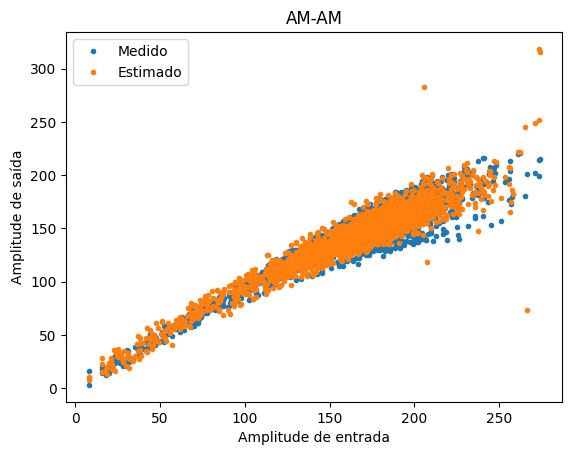

In [24]:

import numpy as np
import matplotlib.pyplot as plt



nmse_calculo = lambda predicted_val, data_out:10 * np.log10(np.mean(np.abs(data_out - predicted_val) ** 2) / np.mean(np.abs(data_out) ** 2))
coefs_finais = (params_int[:num_coefs] + 1j * params_int[num_coefs:]) 

in_data_val_fixed = np.round(in_val_norm * scale) 
out_data_val_fixed = np.round(out_val_norm * scale)
predicted_val = aplica_modelo_int(in_data_val_fixed.reshape(-1,1), coefs_finais, ordem, memoria, precision)

nmse_target = nmse_calculo(predicted_val[memoria:], out_data_val_fixed[memoria:])

print(f"valor de NMSE: {nmse_target}")

plt.figure()
plt.plot(np.abs(in_data_val_fixed[memoria:]), np.abs(out_data_val_fixed[memoria:]), '.', label='Medido')
plt.plot(np.abs(in_data_val_fixed[memoria:]), np.abs(predicted_val[memoria:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.show()

In [ ]:
from scipy.optimize import dual_annealing

melhor_nmse_global = np.inf
melhor_params_global = None

def erro_mp_complex_dual(params_float, x_in_float, y_out_float, ordem, memoria, precision):
    scale = 2**precision
    num_coef = ordem * (memoria + 1)

    params_int = np.round(params_float).astype(int)

    ar = params_int[:num_coef] / scale
    ai = params_int[num_coef:] / scale
    coefs = ar + 1j * ai

    N = len(x_in_float)
    y_est = np.zeros(N, dtype=complex)

    xq = np.round(x_in_float * scale) / scale

    for n in range(memoria, N):
        soma_real = 0.0
        soma_imag = 0.0
        idx = 0

        for m in range(memoria + 1):
            xr0 = np.real(xq[n - m])
            xi0 = np.imag(xq[n - m])

            xr_p = xr0
            xi_p = xi0

            for p in range(1, ordem + 1):

                if p > 1:
                    real_mult = xr_p * xr0 - xi_p * xi0
                    imag_mult = xr_p * xi0 + xi_p * xr0
                    xr_p = np.round(real_mult * scale) / scale
                    xi_p = np.round(imag_mult * scale) / scale

                ar_c = float(np.real(coefs[idx]))
                ai_c = float(np.imag(coefs[idx]))

                pr = ar_c * xr_p - ai_c * xi_p
                pi = ar_c * xi_p + ai_c * xr_p

                pr_q = np.round(pr * scale) / scale
                pi_q = np.round(pi * scale) / scale

                soma_real += pr_q
                soma_imag += pi_q

                idx += 1

        y_est[n] = soma_real + 1j * soma_imag

    return nmse_calculo(y_est[memoria:], y_out_float[memoria:])


# 2) 10 EXECUÇÕES ALEATÓRIAS
# ============================
print("Rodando 10 execuções com chutes aleatórios...")

for k in range(10):

    x0_random = np.random.randint(-255, 256, size=total_params)

    result = dual_annealing(
        erro_mp_complex_dual,
        bounds,
        x0=x0_random.astype(float),
        args=(in_ext_norm, out_ext_norm, ordem, memoria, precision),
        maxiter=500,
        initial_temp=5230,
        visit=2.7,
        accept=-5.0,
        no_local_search=True
    )

    params_int = np.round(result.x).astype(int)
    nmse = result.fun

    print(f"Execução {k+1} → NMSE = {nmse:.4f}")

    if nmse < melhor_nmse_global:
        melhor_nmse_global = nmse
        melhor_params_global = params_int


# ============================
# RESULTADO FINAL
# ============================
num_coefs = ordem * (memoria + 1)

coefs_finais = (
    melhor_params_global[:num_coefs] +
    1j * melhor_params_global[num_coefs:]
) / scale

print("\n================ RESULTADO FINAL ================\n")
print("Melhor NMSE encontrado:", melhor_nmse_global)
print("Coeficientes inteiros finais:")
print(melhor_params_global)
print("\nCoeficientes complexos finais:")
print(coefs_finais)
